Image size: (298, 540, 3)
Plate detected at position: (127, 119, 281, 96)
Plate size: (96, 281, 3)
Blue pixel ratio in detected plate: 0.65
Number of candidates: 1


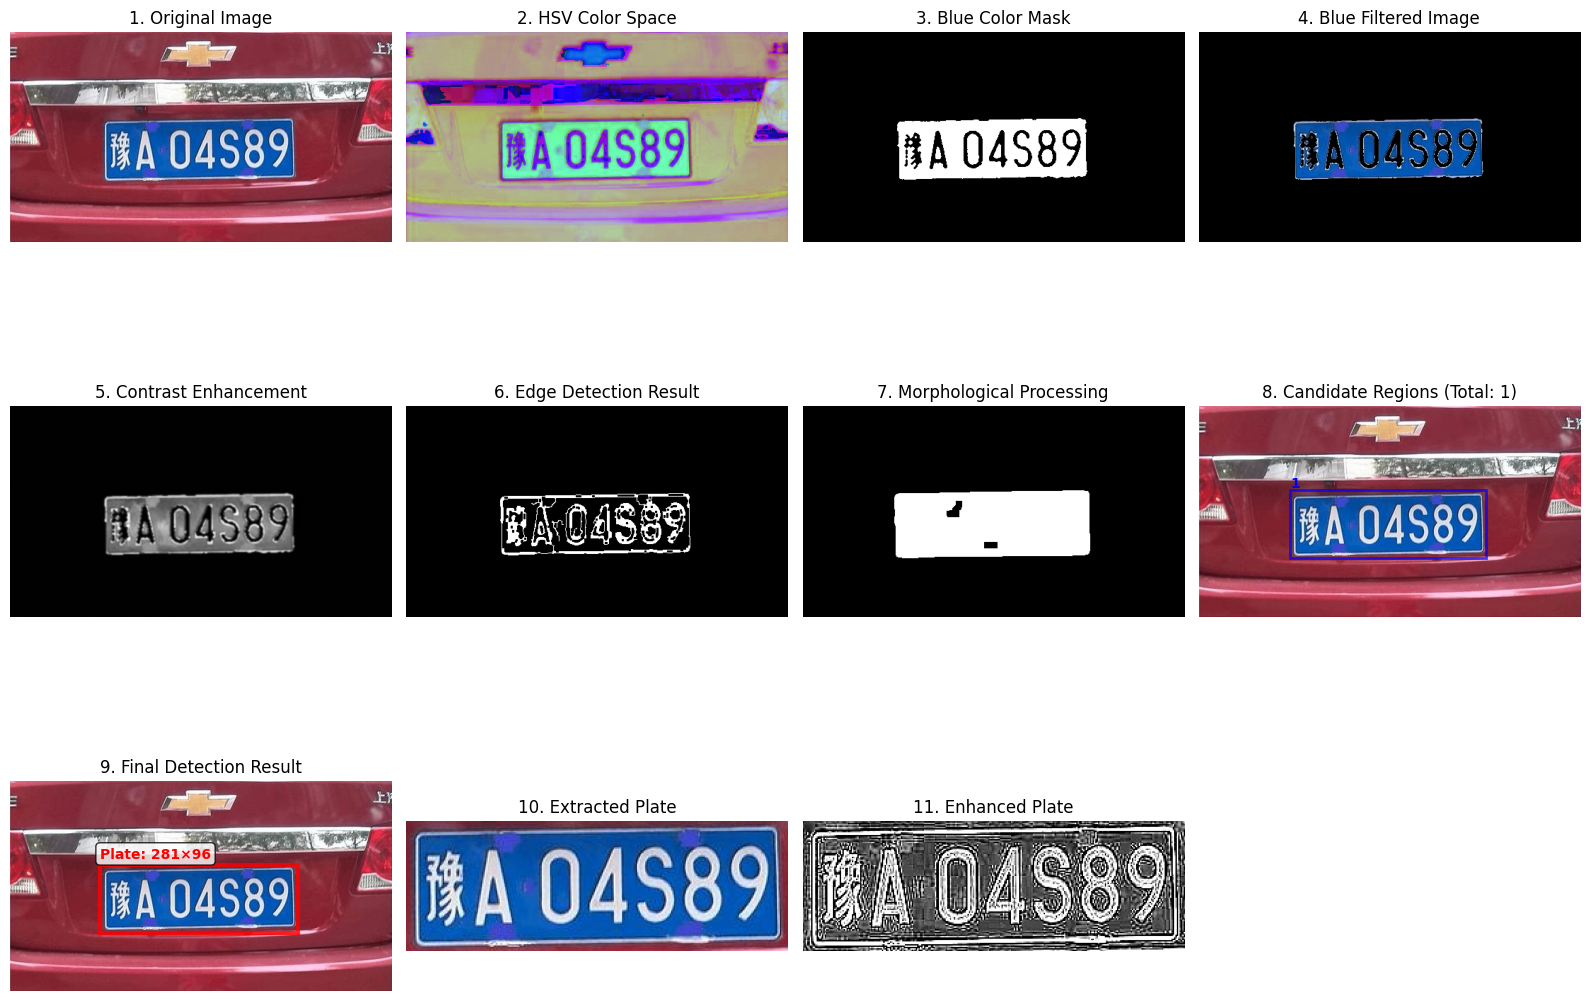

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def preprocess_image(img):
    """预处理图像，针对中国蓝色车牌进行颜色过滤"""
    
    # Stage 1: 蓝色车牌颜色过滤
    # 转换到HSV颜色空间，更适合颜色过滤
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 定义蓝色车牌的HSV范围
    # 中国蓝色车牌的蓝色范围
    lower_blue = np.array([100, 50, 50])   # 较低的蓝色阈值
    upper_blue = np.array([130, 255, 255]) # 较高的蓝色阈值
    
    # 创建蓝色掩码
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # 形态学操作去除噪声
    kernel_noise = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel_noise)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel_noise)
    
    # Stage 2: 应用颜色掩码到原图
    blue_filtered = cv2.bitwise_and(img, img, mask=blue_mask)
    
    # Stage 3: 转换为灰度图用于后续处理
    gray = cv2.cvtColor(blue_filtered, cv2.COLOR_BGR2GRAY)
    
    # Stage 4: 噪声减少
    smooth = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Stage 5: 对比度增强 (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(smooth)

    # Stage 6: 边缘检测
    edges = cv2.Canny(enhanced, 50, 150, apertureSize=3)
    
    # 形态学操作连接断开的边缘
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    return edges, enhanced, blue_mask, blue_filtered

def localize_plate(img, preprocessed, enhanced, blue_mask):
    """定位车牌，结合颜色信息和形状特征"""
    
    # 多尺度形态学操作
    # 水平方向的核，用于连接字符
    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    # 垂直方向的核，用于填充字符内部
    kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))
    
    # 先水平连接，再垂直填充
    morph = cv2.morphologyEx(preprocessed, cv2.MORPH_CLOSE, kernel_horizontal)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel_vertical)
    
    # 膨胀操作，确保车牌区域完整
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph = cv2.dilate(morph, kernel_dilate, iterations=2)
    
    # 结合蓝色掩码信息
    # 对蓝色掩码也进行形态学操作
    kernel_blue = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
    blue_morph = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel_blue)
    blue_morph = cv2.dilate(blue_morph, kernel_dilate, iterations=1)
    
    # 组合边缘信息和颜色信息
    combined = cv2.bitwise_or(morph, blue_morph)

    # 寻找轮廓
    contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    h_img, w_img = img.shape[:2]

    for cnt in contours:
        # 计算边界框
        x, y, w, h = cv2.boundingRect(cnt)
        
        # 改进的车牌特征判断
        aspect_ratio = w / float(h)
        area = w * h
        extent = cv2.contourArea(cnt) / (w * h) if w * h > 0 else 0
        
        # 检查该区域内的蓝色像素比例
        roi_blue_mask = blue_mask[y:y+h, x:x+w]
        blue_pixel_ratio = np.sum(roi_blue_mask > 0) / (w * h) if w * h > 0 else 0
        
        # 车牌的宽高比通常在2.5-5.5之间
        # 面积约束：不能太小或太大
        # extent用于过滤不规则形状
        # 蓝色像素比例应该足够高
        if (2.0 < aspect_ratio < 6.0 and 
            3000 < area < 80000 and 
            extent > 0.2 and
            w > 80 and h > 20 and
            blue_pixel_ratio > 0.1):  # 至少10%的蓝色像素
            
            # 计算轮廓的凸包面积比，车牌应该比较规整
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            if hull_area > 0:
                solidity = cv2.contourArea(cnt) / hull_area
                if solidity > 0.6:  # 稍微放宽要求
                    candidates.append((x, y, w, h, area, aspect_ratio, blue_pixel_ratio))

    if not candidates:
        return None, None, candidates

    # 选择最佳候选区域
    # 优先选择蓝色像素比例高、面积适中、宽高比合理的区域
    def score_candidate(candidate):
        x, y, w, h, area, ar, blue_ratio = candidate
        # 面积得分：中等面积得分高
        area_score = min(area / 15000, 15000 / area) if area > 0 else 0
        # 宽高比得分：接近3.5的得分高
        ar_score = 1 / (1 + abs(ar - 3.5))
        # 位置得分：在图片下半部分得分高（车牌通常在下方）
        pos_score = 1 if y > h_img * 0.3 else 0.5
        # 蓝色比例得分：蓝色像素越多得分越高
        blue_score = min(blue_ratio * 5, 1.0)  # 最高1.0分
        
        return area_score * ar_score * pos_score * blue_score

    best_candidate = max(candidates, key=score_candidate)
    x, y, w, h = best_candidate[:4]
    
    # 扩展边界框，确保包含完整车牌
    margin_x = int(w * 0.01)  # 左右各扩展1%
    margin_y = int(h * 0.01)  # 上下各扩展1%
    
    x = max(0, x - margin_x)
    y = max(0, y - margin_y)
    w = min(w_img - x, w + 2 * margin_x)
    h = min(h_img - y, h + 2 * margin_y)
    
    plate_rect = (x, y, w, h)
    plate_img = img[y:y+h, x:x+w]

    return plate_img, plate_rect, candidates

def enhance_plate_image(plate_img):
    """对提取的车牌图像进行进一步增强"""
    if plate_img is None:
        return None
    
    # 转为灰度图
    if len(plate_img.shape) == 3:
        gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = plate_img
    
    # 自适应直方图均衡化
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # 锐化
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)
    
    return sharpened

def visualize_results(img, preprocessed, enhanced, blue_mask, blue_filtered, plate_img, plate_rect, candidates, enhanced_plate):
    """使用matplotlib可视化所有结果"""
    
    # 创建子图 - 3行4列，只显示11个子图
    fig = plt.figure(figsize=(16, 12))
    
    # 1. 原始图像
    ax1 = plt.subplot(3, 4, 1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('1. Original Image', fontsize=12)
    plt.axis('off')
    
    # 2. HSV颜色空间
    ax2 = plt.subplot(3, 4, 2)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    plt.imshow(hsv)
    plt.title('2. HSV Color Space', fontsize=12)
    plt.axis('off')
    
    # 3. 蓝色掩码
    ax3 = plt.subplot(3, 4, 3)
    plt.imshow(blue_mask, cmap='gray')
    plt.title('3. Blue Color Mask', fontsize=12)
    plt.axis('off')
    
    # 4. 蓝色过滤结果
    ax4 = plt.subplot(3, 4, 4)
    blue_filtered_rgb = cv2.cvtColor(blue_filtered, cv2.COLOR_BGR2RGB)
    plt.imshow(blue_filtered_rgb)
    plt.title('4. Blue Filtered Image', fontsize=12)
    plt.axis('off')
    
    # 5. 对比度增强
    ax5 = plt.subplot(3, 4, 5)
    plt.imshow(enhanced, cmap='gray')
    plt.title('5. Contrast Enhancement', fontsize=12)
    plt.axis('off')
    
    # 6. 边缘检测结果
    ax6 = plt.subplot(3, 4, 6)
    plt.imshow(preprocessed, cmap='gray')
    plt.title('6. Edge Detection Result', fontsize=12)
    plt.axis('off')
    
    # 7. 形态学处理结果
    ax7 = plt.subplot(3, 4, 7)
    # 获取形态学处理的中间结果
    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))
    morph = cv2.morphologyEx(preprocessed, cv2.MORPH_CLOSE, kernel_horizontal)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel_vertical)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph = cv2.dilate(morph, kernel_dilate, iterations=2)
    
    plt.imshow(morph, cmap='gray')
    plt.title('7. Morphological Processing', fontsize=12)
    plt.axis('off')
    
    # 8. 候选区域检测
    ax8 = plt.subplot(3, 4, 8)
    plt.imshow(img_rgb)
    # 绘制所有候选区域（蓝色）
    if candidates:
        for i, candidate in enumerate(candidates):
            x, y, w, h = candidate[:4]
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', 
                           facecolor='none', alpha=0.7)
            ax8.add_patch(rect)
            plt.text(x, y-5, f'{i+1}', color='blue', fontsize=10, fontweight='bold')
    
    plt.title(f'8. Candidate Regions (Total: {len(candidates) if candidates else 0})', fontsize=12)
    plt.axis('off')
    
    # 9. 最终检测结果
    ax9 = plt.subplot(3, 4, 9)
    plt.imshow(img_rgb)
    if plate_rect:
        x, y, w, h = plate_rect
        rect = Rectangle((x, y), w, h, linewidth=3, edgecolor='red', 
                        facecolor='none', alpha=0.8)
        ax9.add_patch(rect)
        plt.text(x, y-10, f'Plate: {w}×{h}', color='red', fontsize=10, 
                fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.title('9. Final Detection Result', fontsize=12)
    plt.axis('off')
    
    # 10. 提取的车牌图像
    ax10 = plt.subplot(3, 4, 10)
    if plate_img is not None:
        plate_rgb = cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB)
        plt.imshow(plate_rgb)
        plt.title('10. Extracted Plate', fontsize=12)
    else:
        plt.text(0.5, 0.5, 'No Plate Detected', ha='center', va='center', transform=ax10.transAxes)
        plt.title('10. Extracted Plate', fontsize=12)
    plt.axis('off')
    
    # 11. 增强后的车牌图像
    ax11 = plt.subplot(3, 4, 11)
    if enhanced_plate is not None:
        plt.imshow(enhanced_plate, cmap='gray')
        plt.title('11. Enhanced Plate', fontsize=12)
    else:
        plt.text(0.5, 0.5, 'No Enhancement Result', ha='center', va='center', transform=ax11.transAxes)
        plt.title('11. Enhanced Plate', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def detect_license_plate(img_path):
    """完整的车牌检测流程，针对中国蓝色车牌优化"""
    # 读取图像
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read image: {img_path}")
        return None
    
    print(f"Image size: {img.shape}")
    
    # 预处理（包含蓝色车牌颜色过滤）
    preprocessed, enhanced, blue_mask, blue_filtered = preprocess_image(img)
    
    # 定位车牌
    plate_img, plate_rect, candidates = localize_plate(img, preprocessed, enhanced, blue_mask)
    
    # 增强车牌图像
    enhanced_plate = None
    if plate_img is not None:
        enhanced_plate = enhance_plate_image(plate_img)
        print(f"Plate detected at position: {plate_rect}")
        print(f"Plate size: {plate_img.shape}")
        
        # 计算蓝色像素比例
        x, y, w, h = plate_rect
        roi_blue_mask = blue_mask[y:y+h, x:x+w]
        blue_ratio = np.sum(roi_blue_mask > 0) / (w * h) if w * h > 0 else 0
        print(f"Blue pixel ratio in detected plate: {blue_ratio:.2f}")
    else:
        print("No license plate detected")
    
    print(f"Number of candidates: {len(candidates) if candidates else 0}")
    
    # 可视化结果
    visualize_results(img, preprocessed, enhanced, blue_mask, blue_filtered, 
                     plate_img, plate_rect, candidates, enhanced_plate)
    
    return {
        'original': img,
        'preprocessed': preprocessed,
        'enhanced': enhanced,
        'blue_mask': blue_mask,
        'blue_filtered': blue_filtered,
        'plate_image': plate_img,
        'enhanced_plate': enhanced_plate,
        'plate_rect': plate_rect,
        'candidates': candidates
    }

# 测试您的图像
if __name__ == "__main__":
    result = detect_license_plate('data/1.jpg')
